In [1]:
import matplotlib
from matplotlib import pyplot as plt
import os

In [2]:
# Everything goes through this class
from pahfit.model import Model
from pahfit.helpers import read_spectrum

# We use Spectrum1D as input
from specutils import Spectrum1D

# PAHFIT demonstration

## 1. Goal and method

PAHFIT is a python package that can decompose astronomical spectra into emission lines, broad dust features, and continua, including an attenuation law. In practice, the decomposition consists of a fit of a multi-component model to the given data, using a chi squared minimization. This fit results in a set of parameters for each component, describing their properties (e.g. emission strength) while being corrected for the continuum and the attenuation.

### Model & Science packs
The model is fully customizable, meaning that the features to be fit can be freely added, removed, or adjusted to better match the observable features of the object at hand. PAHFIT comes with several model setups included, which include the most common dust features and lines. These are called science packs.

### Instrument packs
PAHFIT comes with several instrument packs, which describe the resolution of the supported NIR and MIR instruments as a function of wavelength. These packs are used to determine the FWHM of unresolved lines, so that those line widths can remain fixed during the fitting process. This allows for faster fits, with fewer problems.


## 2. Using PAHFIT in a nutshell

In [3]:
# to be set by user

spectrumfile = "M101_Nucleus_irs.ipac"
instrumentname = "spitzer.irs.*.[12]"
packfile = "classic.yaml"

In [4]:
# model setup
model = Model.from_yaml(packfile)

In [5]:
# spectrum setup and fit
spec = read_spectrum(spectrumfile)
spec.meta['instrument'] = instrumentname
spec.set_redshift_to(0)
model.guess(spec)
model.fit(spec)

/Users/ameeksidhu/opt/anaconda3/envs/pahfit_test/lib/python3.10/site-packages/numpy/ma/core.py:1156: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Number of calls to function has reached maxfev = 1000.


In [6]:
# show results and save
display(model)
fn = 'orion_d5_iso_fit.ecsv'
if not os.path.isfile(fn):
    model.save(fn)

name,group,kind,temperature,tau,wavelength,power,fwhm,model,geometry
,,,K,,um,,um,,
str11,str12,str14,int64,float64,float64,float64,float64,str15,str5
starlight,_none_,starlight,5000 (Fixed),"0 (0, inf)",<n/a>,<n/a>,<n/a>,--,--
dust_cont00,dust_cont,dust_continuum,300 (Fixed),"2.644e-08 (0, inf)",<n/a>,<n/a>,<n/a>,--,--
dust_cont01,dust_cont,dust_continuum,200 (Fixed),"3.583e-08 (0, inf)",<n/a>,<n/a>,<n/a>,--,--
dust_cont02,dust_cont,dust_continuum,135 (Fixed),"0 (0, inf)",<n/a>,<n/a>,<n/a>,--,--
dust_cont03,dust_cont,dust_continuum,90 (Fixed),"6.354e-05 (0, inf)",<n/a>,<n/a>,<n/a>,--,--
dust_cont04,dust_cont,dust_continuum,65 (Fixed),"0.00113 (0, inf)",<n/a>,<n/a>,<n/a>,--,--
...,...,...,...,...,...,...,...,...,...
PAH_17a,PAH_17_cmp,dust_feature,<n/a>,<n/a>,16.45 (Fixed),"16.34 (0, inf)",0.2303 (Fixed),--,--


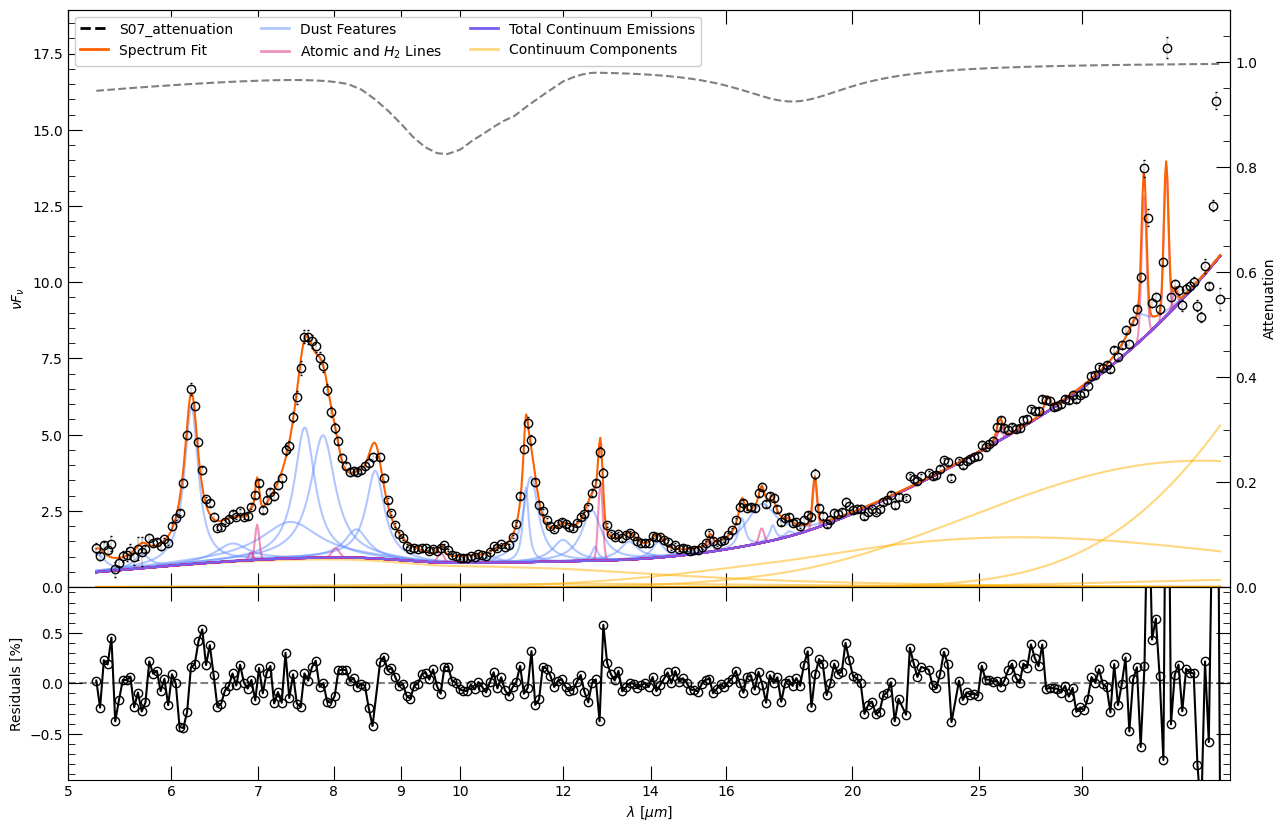

In [7]:
model.plot(spec)

## 3. Step by step explanation

In this section, we take a closer look at the crucial steps of fitting with PAHFIT:
   
    a. Loading observational data in the right format
    b. Setting up a model compatible with these observations
    c. Performing the fit
    d. Inspecting and/or saving the results

### a. Load spectrum

The input format is the Spectrum1D class from specutils. It provides a straightforward way to deal with the wavelengths, fluxes, and uncertainties. JWST data files are natively supported by `Spectrum1D.read()`. PAHFIT comes with several example spectra, located in `pahfit/data`. To load one of these, a utility function is available in `pahfit.helpers`.

Uncertainties for these spectral data are required. The 'uncertainty' member of a Spectrum1D object should be automatically populated, if the provided data is in a standard format (e.g. IPAC or JWST fits files), and includes uncertainties.

In [ ]:
from pahfit.helpers import read_spectrum

# choose your data here
spectrumfile = "M101_Nucleus_irs.ipac"
spec = read_spectrum(spectrumfile)

# this returns a Spectrum1D, with uncertainties set
type(spec)

### b. Set up the model

To set up a model that is compatible with the data that were just loaded, several choices need to be made.
1. A science pack compatible with the *astronomical object* in your data. This means that it needs to contain all of the features that can be observed. More information about setting up science packs can be found at [documentation link]. In this case, the 'classic.yaml' science pack was optimized to fit extragalactic targets.
2. An instrument specification compatible with the *observatory and instrument settings*. The instrument is specified as a string, or as a list of strings. More info at [documentation link]. Since the included M101 data were observed with Spitzer IRS, and combined from the  LL1, LL2, SL1, and SL2 segments, the correct instrument pack is `spitzer.irs.`, followed by those four combinations (see code below). Generally, every entry in an instrument pack represents on spectroscopic segment of the instrument, and the data specifies what the resolution is at every wavelength. This information is used to determine appropriate widths for the unresolved lines. To find which other options are available, open the `spitzer.yaml` science pack in a text editor.

Once you have chosen the appropriate science pack and instrument specification, this information can be passed as follows
- The science pack file name is passed to the Model class to set up the model.
- The instrument specification is associated with the spectrum data. This is done by setting the 'instrument' metadata of the Spectrum1D object. PAHFIT will raise an Error if you forget to do this.
- The redshift can also be provided, via the spec.redshift attribute. This is used to determine width of the lines in the instrument reference frame, and perform the fit can be performed in the rest frame. The physical parameters specified by the science pack are in the rest frame of the object.

In [ ]:
# The right path to one of the default science packs will be automatically found
packfile = "classic.yaml"

# this creates a Model instance
model1 = Model.from_yaml(packfile)
model1

# This wildcard syntax can be used to specify multiple spectral segments
instrumentname = f"spitzer.irs.*.[12]"

# add instrument info to the spectrum that was loaded above
spec.meta['instrument'] = instrumentname
spec.set_redshift_to(0)

### c: Perform initial guess and fit the model

The initial guess is optional, but usually necessary, as the default values (zeros) are not fitter-friendly. Guess will use some very simple heuristics (e.g. average flux) to start the fit from non-zero values with the right order of magnitude.

When fit is called, a parametric function is constructed which describes the flux as a function of wavelength. The observables we are interested in are the parameters of this function. They are fit to the spectrum the user passes as an argument, and the results are stored in the internal state of the model, in this case model.features. 

    Note: more advanced initial guesses will be implemented in the future

In [ ]:
model1.guess(spec)

In [ ]:
model1.fit(spec)

### d: Inspect and save the results

Now that the model is in a "fitted" state, we can plot it, or look at the numerical values of the fit by inspecting the features table. Note that the plot and feature table can be shown at any point in the lifetime of the model, even before fitting anything. This can be useful to inspect the model setup, or the model guessing. The features table has all the features of an astropy table, and can be sliced for easier inspection.

In [ ]:
# make the classic PAHFIT plot
model1.plot(spec)

In [ ]:
# inspect the numbers
model1.features

In [ ]:
# what are the results for the [SIII]_18 line at 18.7 micron?
model1.features.loc['[SIII]_18']

In [ ]:
fn = 'classic_fit.ecsv'
if not os.path.isfile(fn):
    model1.save(fn)

## 4. Advanced features

### Copy model and edit features table manually

One of the more powerful things about the new python interface, is that the features table can be edited on the fly. This can be used to tweak the initial guess, or to experiment with adding or removing certain features, without having to edit the yaml file.

In [ ]:
# make a copy of our previous model
model2 = model1.copy()
# what if I shift this line a little bit
# original value wavelength = 18.71, power = 31.63
model2.features.loc['[SIII]_18']['wavelength'][0] = 18.76
# now redo the fit and make a plot again
model2.fit(spec)
print(model2.features.loc['[SIII]_18'])
model2.plot(spec)

### Inspect fit status

Under the hood, the fitting happens through the Astropy model fitting framework. A dictionary called fit_info is returned and stored as a member. It contains the output values of the underlying scipy routine. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html for the meaning of the values in this dict. A handful of extra values are added by astropy, such as cov_x, the covariance matrix of the fit parameters. It is often None due to issues with the underlying numerical method.

In the near future, we aim to provide a more robust way to estimate the uncertainty and covariance of the fit results.

In [ ]:
model2.fit_info

### Load saved model

The models store sufficient information in the metadata, so that they can be reloaded from a save file. The reloaded models can be used to e.g. make a plot of a previous fit, or to use a previous fit as an advanced initial guess.

In [ ]:
model3 = Model.from_saved('orion_d5_iso_fit.ecsv')
model3

In [ ]:
# inspect previous results
# model3.plot(spec)
# do another fit
# model3.fit(spec)

## 5. Preparing input for PAHdb

In the next part of this community telecon, the PAHdb tool needs spectra that contain only dust features, without the effects of the attenuation, continuum, or lines. PAHFIT can be used to perform these corrections.

This example uses data of VV114, a pair of merging galaxies. The spectrum was created by applying an aperture extraction to the MIRI MRS datacube. The line fits are not perfect, and there are still some artifacts in the MIRI data. But the fit is good enough to extract a dust emission spectrum.

In [ ]:
# the observational data
spec = Spectrum1D.read('region_3_miri.tbl', format='IPAC')
display(spec.meta)
spec

In [ ]:
from astropy.units import Quantity
z = 0.02035
spec.set_redshift_to(z)
spec.meta['instrument'] = 'jwst.miri.*.*'
model4 = Model.from_yaml('classic.yaml')
model4.guess(spec)
model4.fit(spec)
model4.plot(spec)

In [ ]:
#model4.features[model4.features['group'] == 'ionic_lines']
model4.features

In [ ]:
fn = 'region_3_miri_fit.ecsv'
if not os.path.isfile(fn):
    model4.save(fn)

### Extract dust features only

The `sub_model()` function will return a functional (flux as a function of wavelength) including only features of the requested kind. When kind is set to "dust_feature", we obtain a functional representation of the combined emission spectrum of all the dust features.

In the plot, observe how the extracted dust features around 10 micron are much brighter than observed in the data. This is because of the attenuation correction.

In [ ]:
# the instrument and redshift are still required here, to keep only the features that were fit in the data range
df = model4.sub_model(instrumentname=spec.meta['instrument'], redshift=spec.redshift, kind='dust_feature')
df

In [ ]:
oneplusz = 1 + z
wrest = spec.spectral_axis.value / oneplusz

plt.figure()
plt.plot(spec.spectral_axis.value, spec.flux.value, ls='none', marker='.', color='xkcd:light red', alpha=0.1, label='data')
plt.plot(wrest, spec.flux.value * oneplusz, ls='none', marker='.', color='k', alpha=0.5, label='data z-corrected')
plt.plot(wrest, df(wrest), label='dust features corrected for z, continuum, attenuation')
plt.gcf().set_size_inches(10, 4)
plt.ylim([0, 0.1])
plt.legend()
plt.show()

We tabulate this function here. This is how the data for the PAHdb demonstration were created!

In [ ]:
# save the spectrum using the (native spectrum1d writer doesnt support ascii though)
from astropy.table import Table
pah_spectrum = Spectrum1D(spectral_axis=wrest * spec.spectral_axis.unit, flux=df(wrest) * spec.flux.unit)
# pah_spectrum.write('pah_spectrum.fits', format='tabular-fits')
t = Table()
t.add_column(pah_spectrum.spectral_axis, name='WAVELENGTH')
t.add_column(pah_spectrum.flux, name='FLUX')
t.write('region_3_miri_pah.ecsv', format='ascii.ecsv', overwrite=True)